In [1]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask_jobqueue
import dask
from distributed import Client
from dask.diagnostics import progress
from tqdm.autonotebook import tqdm
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import intake
import fsspec
#import seaborn as sns
import gcsfs
import cftime
import pandas as pd
import xesmf as xe
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
# import logging
# logging.basicConfig(level=logging.DEBUG)  # Set logging level to DEBUG

/tmp/ipykernel_2842332/1003720280.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
################################
savefigs   = '/global/scratch/users/harsha/savefigs/Feb21/'
cesm2_path = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
cvals      = '/global/scratch/users/harsha/LENS/cesm2/cvals/detrended/'
############
pi_year  = 1865
eoc_year = 2085

In [4]:
job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=condo_cumulus_lr6','--account=lr_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=lr_lowprio','--account=ac_cumulus']
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=10, walltime='5:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(3)

In [5]:
cluster

Dashboard: http://10.0.39.4:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.39.4:37371,Workers: 0
Dashboard: http://10.0.39.4:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [6]:
chicago_lat=41.88
chicago_lon=(360-87.6298)%360
# #
# cvals_ = '/Users/hrh/Desktop/TwoMoments21/cvals/cmip6/'

In [7]:
# calculate global means
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'quantile'}
    return (ds * weight).mean(other_dims)

def detrend_all(ds, central_year):
    # Assumes that the ds has coordinates day, year and member.
    
    #Fit a linear fuction and extract slope
    pcoeffs = ds.mean('member').polyfit(dim='year',deg=1)
    slope   = pcoeffs.polyfit_coefficients.sel(degree=1)
    
    #Calculate trend
    ds_trend   = slope*(ds['year']- central_year)
    
    #Detrend by subtracting the trend from the data
    ds_detrended = ds  - ds_trend
    
    return ds_detrended

In [8]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


In [11]:
# 2. Search for maximum temperature for son 30
expts = ['ssp370','historical']

cat = col.search(
    experiment_id=expts,
    table_id='day',
    variable_id='tasmax',
    #grid_label='gn'
)

query = dict(
    experiment_id=expts,
    table_id='day',
    variable_id=['tasmax'],
    member_id = 'r1i1p1f1',
)

col_subset = col.search(require_all_on=["source_id"], **query)
col_subset.df.groupby("source_id")[
    ["experiment_id", "variable_id", "table_id","member_id"]
].nunique()

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/intake_esm/_search.py:82: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for _, group in grouped:


,experiment_id,variable_id,table_id,member_id
source_id,,,,
ACCESS-CM2,2,1,1,1
AWI-CM-1-1-MR,2,1,1,1
BCC-ESM1,2,1,1,1
CMCC-ESM2,2,1,1,1
CanESM5,2,1,1,1
EC-Earth3,2,1,1,1
EC-Earth3-AerChem,2,1,1,1
EC-Earth3-Veg-LR,2,1,1,1
FGOALS-g3,2,1,1,1


In [12]:
df = col_subset.df
model_counts = df.groupby('source_id').size()
print(model_counts)

source_id
ACCESS-CM2           2
AWI-CM-1-1-MR        2
BCC-ESM1             2
CMCC-ESM2            2
CanESM5              2
EC-Earth3            2
EC-Earth3-AerChem    2
EC-Earth3-Veg-LR     2
FGOALS-g3            2
GFDL-ESM4            2
INM-CM4-8            2
INM-CM5-0            2
IPSL-CM6A-LR         2
KACE-1-0-G           2
MIROC6               2
MPI-ESM-1-2-HAM      2
MPI-ESM1-2-HR        2
MPI-ESM1-2-LR        2
MRI-ESM2-0           2
NorESM2-LM           2
NorESM2-MM           2
dtype: int64


In [8]:
def drop_all_bounds(ds):
    drop_vars = [vname for vname in ds.coords
                 if (('_bounds') in vname ) or ('_bnds') in vname]
    return ds.drop(drop_vars)

def open_dset(df):
    assert len(df) == 1
    ds = xr.open_zarr(fsspec.get_mapper(df.zstore.values[0]), consolidated=True)
    return drop_all_bounds(ds)

def open_delayed(df):
    return dask.delayed(open_dset)(df)

from collections import defaultdict
dsets = defaultdict(dict)

for group, df in col_subset.df.groupby(by=['source_id', 'experiment_id']):
    dsets[group[0]][group[1]] = open_delayed(df)

NameError: name 'col_subset' is not defined

In [13]:
%%time
# Trigger computation
dsets_ = dask.compute(dict(dsets))[0]

CPU times: user 8.93 s, sys: 786 ms, total: 9.72 s
Wall time: 48.1 s


In [14]:
#Define coarse grid to regrid on
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 91, 3)),
                     'lon': (['lon'], np.arange(0, 361, 3)),})

In [9]:
def drop_feb29(ds):
    # Check if the dataset's calendar is not '360_day'
    calendar = ds.time.encoding.get('calendar', None)
    print(ds.attrs['source_id'],calendar)
    if calendar != '360_day':
        ds = ds.convert_calendar('365_day')
    return ds


def to_daily(ds):
    # Check and deal with different datetime types
    if isinstance(ds['time'].values[0], np.datetime64):
        pass
    elif isinstance(ds['time'].values[0], cftime.datetime):
        pass
    else:
        # convert time coordinate to datetime64 objects
        ds['time'] = ds['time'].astype('datetime64[ns]')
    year      = ds.time.dt.year
    dayofyear = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), dayofyear=("time", dayofyear.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "dayofyear")).unstack("time")  


def extract_data(ds):
    """
    Extract data for djf from the dataset 'ds' for specific time and spatial range.

    Parameters:
    - ds (xarray.Dataset): Input dataset

    Returns:
    - xarray.Dataset: Dataset subsetted for djf and the specified space and time range.
    """    

    subset1 = ds.sel(year=slice(1850, 1879))
    subset2 = ds.sel(year=slice(2071, 2100))
    
    subset = xr.concat([subset1, subset2], dim='year')  

    return subset

def is_leap(year):
    """Check if a year is a leap year."""
    return (year % 4 == 0) and ((year % 100 != 0) or (year % 400 == 0))



In [9]:
quants = np.linspace(0,1.0,30)


def compute_quantiles(ds, quantiles=quants):
    return ds.chunk(dict(year=-1)).quantile(quantiles, dim='year',skipna=False)

def regrid(ds, ds_out):
    experiment_id = ds.attrs['experiment_id']
    source_id     = ds.attrs['source_id']
    #regrid
    regridder = xe.Regridder(ds, ds_out, 'nearest_s2d', reuse_weights=False)
    ds_new    = regridder(ds)
    
#     #Assign back attributes as regirdder would have deleted attributes 
    ds_new.attrs['experiment_id'] = experiment_id
    ds_new.attrs['source_id'] = source_id
    
    #print(ds_new.attrs['experiment_id'],ds_new.attrs['source_id'])
    #print(ds_new)
    return ds_new

def process_data(ds, quantiles=quants):
    ds = ds.pipe(drop_feb29).pipe(to_daily).pipe(extract_data)
    
    if len(ds['year']) == 0:
        print("The dataset is empty. Skipping...")
        return None
    
    if len(ds['dayofyear'])<365:
        print('The dataset has less than 365 days. Skipping ..')
        return None
    
    # # Remove 'time' coordinate
    # ds = ds.set_index(time=("year", "dayofyear")).unstack("time")  
   
    
    return (ds.pipe(regrid, ds_out=ds_out)
           )


In [17]:
with progress.ProgressBar():

    expt_da = xr.DataArray(expts, dims='experiment_id', name='experiment_id',
                           coords={'experiment_id': expts})

    # Initialize an Empty Dictionary for Aligned Datasets:
    dsets_aligned = {}

    # Iterate Over dsets_ Dictionary:

    for k, v in tqdm(dsets_.items()):
        # Initialize a dictionary for this source_id
        dsets_aligned[k] = {}
        
        skip_source_id = False

        for expt in expts:
            ds = v[expt].pipe(process_data)

            # Check if the dataset is empty and skip this source_id if so
            if ds is None:
                print(f"Skipping {expt} for {k} because the dataset is empty")
                skip_source_id = True
                break
            
            # Store the dataset in the dictionary
            # dsets_aligned[k][expt] = ds
            # Compute the dataset and store it in the dictionary
            dsets_aligned[k][expt] = ds.compute()
            print(dsets_aligned[k][expt])

        if skip_source_id:
            del dsets_aligned[k]
            continue


  0%|          | 0/21 [00:00<?, ?it/s]

ACCESS-CM2 proleptic_gregorian
<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 258.3 258.3 ... 266.7 266.7
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  ssp370
    source_id:      ACCESS-CM2
ACCESS-CM2 proleptic_gregorian
<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/dataset.py:4880: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 253.6 253.6 ... 244.7 244.7
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  historical
    source_id:      AWI-CM-1-1-MR
BCC-ESM1 noleap
The dataset is empty. Skipping...
Skipping ssp370 for BCC-ESM1 because the dataset is empty
CMCC-ESM2 noleap


/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/dataset.py:4880: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 263.8 263.8 ... 273.9 273.9
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  ssp370
    source_id:      CMCC-ESM2
CMCC-ESM2 noleap


/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/dataset.py:4880: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 255.1 255.1 ... 242.1 242.1
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  historical
    source_id:      CMCC-ESM2
CanESM5 noleap
<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/dataset.py:4880: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 253.0 253.0 ... 272.9 272.9
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  ssp370
    source_id:      EC-Earth3
EC-Earth3 proleptic_gregorian


/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/dataset.py:4880: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 251.8 251.8 ... 239.7 239.7
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  historical
    source_id:      EC-Earth3
EC-Earth3-AerChem proleptic_gregorian


/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/dataset.py:4880: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 251.8 251.8 ... 272.5 272.5
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  ssp370
    source_id:      EC-Earth3-AerChem
EC-Earth3-AerChem proleptic_gregorian


/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/dataset.py:4880: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 251.0 251.0 ... 255.7 255.7
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  historical
    source_id:      EC-Earth3-AerChem
EC-Earth3-Veg-LR proleptic_gregorian
<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/dataset.py:4880: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121, bnds: 2)
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * bnds       (bnds) float64 1.0 2.0
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 249.0 249.0 ... 258.4 258.4
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  ssp370
    source_id:      GFDL-ESM4
GFDL-ESM4 noleap


/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/dataset.py:4880: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121, bnds: 2)
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * bnds       (bnds) float64 1.0 2.0
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 246.0 246.0 ... 242.3 242.3
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  historical
    source_id:      GFDL-ESM4
INM-CM4-8 noleap
<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int6

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/dataset.py:4880: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 245.2 245.2 ... 264.2 264.2
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  ssp370
    source_id:      MPI-ESM1-2-HR
MPI-ESM1-2-HR proleptic_gregorian


/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/dataset.py:4880: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 245.3 245.3 ... 245.9 245.9
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  historical
    source_id:      MPI-ESM1-2-HR
MPI-ESM1-2-LR proleptic_gregorian
<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/dataset.py:4880: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 251.4 251.4 ... 271.4 271.4
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  ssp370
    source_id:      MRI-ESM2-0
MRI-ESM2-0 proleptic_gregorian


/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/dataset.py:4880: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 243.2 243.2 ... 262.8 262.8
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  historical
    source_id:      MRI-ESM2-0
NorESM2-LM noleap
<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/dataset.py:4880: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 253.9 253.9 ... 255.4 255.4
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  ssp370
    source_id:      NorESM2-MM
NorESM2-MM noleap


/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/dataset.py:4880: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 245.6 245.6 ... 236.1 236.1
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  historical
    source_id:      NorESM2-MM


In [18]:
# with progress.ProgressBar():
#     dsets_aligned_ = dask.compute(dsets_aligned)[0]

In [19]:
source_ids = list(dsets_aligned.keys())
source_da = xr.DataArray(source_ids, dims='source_id', name='source_id',
                         coords={'source_id': source_ids})

# final_ds = {expt: xr.concat([ds.get(expt, xr.Dataset()).reset_coords(drop=True)
#                              for ds in dsets_aligned.values()],
#                             dim=source_da)
#             for expt in expts}

final_ds = {expt: xr.concat([ds[expt].reset_coords(drop=True)
                             for ds in dsets_aligned.values() if expt in ds and ds[expt] is not None],
                            dim=source_da, coords='minimal')
            for expt in expts}

final_ds

{'ssp370': <xarray.Dataset>
 Dimensions:    (bnds: 2, source_id: 18, year: 30, dayofyear: 365, lat: 61,
                 lon: 121)
 Coordinates:
   * bnds       (bnds) float64 1.0 2.0
   * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
   * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
   * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
   * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
   * source_id  (source_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
 Data variables:
     tasmax     (source_id, year, dayofyear, lat, lon) float32 258.3 ... 255.4
 Attributes:
     regrid_method:  nearest_s2d
     experiment_id:  ssp370
     source_id:      ACCESS-CM2,
 'historical': <xarray.Dataset>
 Dimensions:    (bnds: 2, source_id: 18, year: 30, dayofyear: 365, lat: 61,
                 lon: 121)
 Coordinates:
   * bnds       (bnds) float64 1.0 2.0
   * year       (year) in

In [20]:
final_ds_pi = xr.concat([ds['historical'].reset_coords(drop=True)
                                 for ds in dsets_aligned.values()],
                                dim=source_da)

final_ds_eoc = xr.concat([ds['ssp370'].reset_coords(drop=True)
                             for ds in dsets_aligned.values()],
                            dim=source_da)
final_ds_eoc

<xarray.Dataset>
Dimensions:    (bnds: 2, source_id: 18, year: 30, dayofyear: 365, lat: 61,
                lon: 121)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * source_id  (source_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
Data variables:
    tasmax     (source_id, year, dayofyear, lat, lon) float32 258.3 ... 255.4
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  ssp370
    source_id:      ACCESS-CM2

In [12]:
# final_ds_eoc = final_ds_eoc.tasmax
# # final_ds_eoc

In [22]:
final_ds_pi = final_ds_pi.tasmax

In [23]:
# %%time
# # final_ds_eoc = final_ds_eoc.dropna(dim='lat',how='all')
# final_ds_eoc.sel(dayofyear=365).sel(lat=chicago_lat,lon=chicago_lon,method='nearest').sel(source_id='AWI-CM-1-1-MR').values

In [25]:
# source_ids = list(dsets_aligned_.keys())
# source_da = xr.DataArray(source_ids, dims='source_id', name='source_id',
#                          coords={'source_id': source_ids})

# final_ds = xr.concat([ds.reset_coords(drop=True)
#                     for ds in dsets_aligned_.values()],
#                     dim=source_da)

# final_ds

In [26]:
# %%time
# final_ds_pi.to_dataset().to_zarr(cvals+'cmip6_pi_quantiles_annual.zarr',mode='w')
# final_ds_eoc.to_dataset().to_zarr(cvals+'cmip6_eoc_quantiles_annual.zarr',mode='w')

CPU times: user 46.1 s, sys: 16.4 s, total: 1min 2s
Wall time: 57 s


In [8]:
final_ds_pi  = xr.open_zarr(cvals+'cmip6_pi_quantiles_annual.zarr').tasmax
final_ds_eoc = xr.open_zarr(cvals+'cmip6_eoc_quantiles_annual.zarr').tasmax
final_ds_eoc

<xarray.DataArray 'tasmax' (source_id: 18, year: 30, dayofyear: 365, lat: 61,
                            lon: 121)>
dask.array<open_dataset-7b83895101ae604b25277a61bd350bc4tasmax, shape=(18, 30, 365, 61, 121), dtype=float32, chunksize=(3, 8, 92, 16, 31), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * source_id  (source_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100

In [30]:
# final_ds_pi  = final_ds_pi.chunk({'year':30,'dayofyear':10})
# final_ds_eoc = final_ds_eoc.chunk({'year':30,'dayofyear':10})
# final_ds_eoc

<xarray.DataArray 'tasmax' (source_id: 18, year: 30, dayofyear: 365, lat: 61,
                            lon: 121)>
dask.array<rechunk-merge, shape=(18, 30, 365, 61, 121), dtype=float32, chunksize=(3, 30, 10, 16, 31), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * source_id  (source_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100

In [9]:
%%time
pcoeffs_ds_pi  = final_ds_pi.polyfit(dim='year',deg=1,skipna=False)
pcoeffs_ds_eoc = final_ds_eoc.polyfit(dim='year',deg=1,skipna=False)
pcoeffs_ds_eoc

CPU times: user 2min 7s, sys: 2min 15s, total: 4min 22s
Wall time: 3min 28s


<xarray.Dataset>
Dimensions:               (source_id: 18, dayofyear: 365, lat: 61, lon: 121,
                           degree: 2)
Coordinates:
  * source_id             (source_id) object 'ACCESS-CM2' ... 'NorESM2-MM'
  * dayofyear             (dayofyear) int64 1 2 3 4 5 6 ... 361 362 363 364 365
  * lat                   (lat) int64 -90 -87 -84 -81 -78 -75 ... 78 81 84 87 90
  * lon                   (lon) int64 0 3 6 9 12 15 ... 345 348 351 354 357 360
  * degree                (degree) int64 1 0
Data variables:
    polyfit_coefficients  (degree, source_id, dayofyear, lat, lon) float64 dask.array<chunksize=(2, 1, 365, 61, 121), meta=np.ndarray>

In [10]:
%%time
m_pi  = pcoeffs_ds_pi.polyfit_coefficients.sel(degree=1)
m_eoc = pcoeffs_ds_eoc.polyfit_coefficients.sel(degree=1)
m_pi

CPU times: user 23.7 ms, sys: 3.25 ms, total: 26.9 ms
Wall time: 27.9 ms


<xarray.DataArray 'polyfit_coefficients' (source_id: 18, dayofyear: 365,
                                          lat: 61, lon: 121)>
dask.array<getitem, shape=(18, 365, 61, 121), dtype=float64, chunksize=(1, 365, 61, 121), chunktype=numpy.ndarray>
Coordinates:
  * source_id  (source_id) object 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
    degree     int64 1

In [11]:
# %%time
# #Save slopes
# m_pi.to_dataset().to_zarr(cvals+'cmip6_pi_trend.zarr',mode='w')
# m_eoc.to_dataset().to_zarr(cvals+'cmip6_eoc_trend.zarr',mode='w')

In [12]:
m_pi  = xr.open_zarr(cvals+'cmip6_pi_trend.zarr').polyfit_coefficients
m_eoc = xr.open_zarr(cvals+'cmip6_eoc_trend.zarr').polyfit_coefficients

In [13]:
#Slopes for Chicago:
print(m_eoc.sel(dayofyear=365).sel(lat=chicago_lat,lon=chicago_lon,method='nearest').values)

[-0.03381247 -0.17608671 -0.01470425  0.11786464  0.06405788  0.15660726
  0.21649881 -0.02547258 -0.06782831 -0.0109792   0.09652032 -0.02416535
  0.06686885  0.06970598  0.02175513 -0.08744665  0.09905171  0.09577478]


In [14]:
print(m_pi.sel(dayofyear=365).sel(lat=chicago_lat,lon=chicago_lon,method='nearest').values)

[ 0.00416625  0.21980229 -0.11749587  0.02476165 -0.05080974 -0.09769662
  0.01526993 -0.17170953 -0.09264809 -0.06825253  0.03342224  0.09182278
 -0.03170195  0.05935102 -0.01321666 -0.10468459 -0.01282127  0.00237965]


In [15]:
#Calculate trend
pi_trend   = m_pi*(final_ds_pi['year']  - pi_year)
eoc_trend  = m_eoc*(final_ds_eoc['year']- eoc_year)
#Subtract trend
ds_pi_det  = final_ds_pi  - pi_trend
ds_eoc_det = final_ds_eoc - eoc_trend
#
ds_pi_det  = ds_pi_det.rename('tasmax')
ds_eoc_det = ds_eoc_det.rename('tasmax')
ds_pi_det

<xarray.DataArray 'tasmax' (source_id: 18, year: 30, dayofyear: 365, lat: 61,
                            lon: 121)>
dask.array<sub, shape=(18, 30, 365, 61, 121), dtype=float64, chunksize=(1, 8, 92, 16, 31), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * source_id  (source_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879
    degree     int64 ...

In [16]:
ds_eoc_det.sel(dayofyear=365).sel(lat=chicago_lat,lon=chicago_lon,method='nearest').sel(source_id='AWI-CM-1-1-MR').values

array([270.11767179, 268.27773677, 284.10082666, 273.81252738,
       281.08074666, 276.40276843, 284.9603859 , 270.69421187,
       276.20638867, 279.0286851 , 282.24966317, 267.68783484,
       274.62676945, 283.11660738, 268.03329468, 280.91363554,
       273.43682918, 276.44830408, 280.44717521, 275.67498922,
       292.61563281, 277.12042436, 276.00363387, 279.43893689,
       269.21332072, 267.43805245, 283.10672339, 285.13235844,
       270.9187662 , 268.11856507])

In [17]:
final_ds_eoc.sel(dayofyear=365).sel(lat=chicago_lat,lon=chicago_lon,method='nearest').sel(source_id='AWI-CM-1-1-MR').values

array([272.5829 , 270.56686, 286.21387, 275.74948, 282.8416 , 277.98755,
       286.36908, 271.92682, 277.2629 , 279.90912, 282.954  , 268.2161 ,
       274.97894, 283.2927 , 268.0333 , 280.73755, 273.08466, 275.92004,
       279.74283, 274.79456, 291.5591 , 275.88782, 274.59494, 277.85416,
       267.45245, 265.5011 , 280.99368, 282.84323, 268.45355, 265.47726],
      dtype=float32)

In [18]:
ds_pi_det['source_id']  = ds_pi_det['source_id'].astype(str)
ds_eoc_det['source_id'] = ds_eoc_det['source_id'].astype(str)

In [19]:
# %%time
# ds_pi_det.to_dataset().to_zarr(cvals+'cmip6_pi_ann_detrended.zarr',mode='w')
# ds_eoc_det.to_dataset().to_zarr(cvals+'cmip6_eoc_ann_detrended.zarr',mode='w')

CPU times: user 7min 32s, sys: 17.5 s, total: 7min 50s
Wall time: 8min 10s


In [10]:
ds_pi_det  = xr.open_zarr(cvals+'cmip6_pi_ann_detrended.zarr').tasmax
ds_eoc_det = xr.open_zarr(cvals+'cmip6_eoc_ann_detrended.zarr').tasmax
#
qpi  = compute_quantiles(ds_pi_det)
qeoc = compute_quantiles(ds_eoc_det)
qano = qeoc - qpi
qano

<xarray.DataArray 'tasmax' (quantile: 30, source_id: 18, dayofyear: 365,
                            lat: 61, lon: 121)>
dask.array<sub, shape=(30, 18, 365, 61, 121), dtype=float64, chunksize=(30, 1, 92, 16, 31), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * source_id  (source_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * quantile   (quantile) float64 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

In [11]:
%%time
test = qano.sel(dayofyear=365).sel(lat=chicago_lat,lon=chicago_lon,method='nearest').\
sel(quantile=0.03448,method='nearest').values

CPU times: user 6.32 s, sys: 326 ms, total: 6.64 s
Wall time: 11.6 s


In [12]:
test

array([ 4.97339247,  3.19495899,  5.06688141, 14.98609247,  3.73884816,
        9.55674148, 13.49184208, 13.22518559,  6.71714727,  2.42355726,
        3.73900106,  9.757262  ,  3.81634905, 11.50711233,  8.04899877,
        3.46947516,  4.20171598,  3.87958733])

In [13]:
test.std()

3.9791766198591207

In [11]:
%%time
qano_std            = qano.std(dim='source_id')
qano_cmip_mean      = qano.mean(dim='source_id')
qano_sq_deviation   = (qano - qano_cmip_mean)**2
qano_sq_deviation

CPU times: user 254 ms, sys: 38.5 ms, total: 293 ms
Wall time: 457 ms


<xarray.DataArray 'tasmax' (quantile: 30, source_id: 18, dayofyear: 365,
                            lat: 61, lon: 121)>
dask.array<pow, shape=(30, 18, 365, 61, 121), dtype=float64, chunksize=(30, 1, 92, 16, 31), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * source_id  (source_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * quantile   (quantile) float64 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

In [12]:
qano_std_agmean  = global_mean(qano_std)
qano_msd         = global_mean(qano_sq_deviation)
qano_rmsd        = np.sqrt(qano_msd)
qano_rmsd

<xarray.DataArray (quantile: 30)>
dask.array<sqrt, shape=(30,), dtype=float64, chunksize=(30,), chunktype=numpy.ndarray>
Coordinates:
  * quantile  (quantile) float64 0.0 0.03448 0.06897 0.1034 ... 0.931 0.9655 1.0

In [16]:
# %%time
# qano_std.sel(dayofyear=365).sel(lat=chicago_lat,lon=chicago_lon,method='nearest').values

In [ ]:
# %%time
# qano_std.sel(dayofyear=365).sel(lat=1,lon=5,method='nearest').values

In [13]:
%%time
qano_std_agmean = qano_std_agmean.rename('tasmax_qanomaly')
qano_rmsd       = qano_rmsd.rename('qanomaly_rmsd')
# qano_std_agmean.to_dataset().to_zarr(cvals+'cmip6_quantiles_ano_agmean.zarr',mode='w')
# qano_rmsd.to_dataset().to_zarr(cvals+'cmip6_qano_ag_rmsd.zarr',mode='w')

CPU times: user 6min 52s, sys: 19.4 s, total: 7min 12s
Wall time: 7min 36s


In [14]:
qano_std_agmean = xr.open_zarr(cvals+'cmip6_quantiles_ano_agmean.zarr').tasmax_qanomaly
qano_std_agmean.values

array([1.81839762, 1.56943722, 1.47226187, 1.41705968, 1.38015611,
       1.35317367, 1.3324081 , 1.31579773, 1.30216332, 1.29048156,
       1.2804823 , 1.27192213, 1.26452121, 1.25822407, 1.25277815,
       1.24821316, 1.24467519, 1.2420058 , 1.24039354, 1.23985372,
       1.24036737, 1.24230723, 1.24585756, 1.25153673, 1.26016892,
       1.27309782, 1.29288206, 1.32523564, 1.38669937, 1.54969364])

In [15]:
qano_rmsd = xr.open_zarr(cvals+'cmip6_qano_ag_rmsd.zarr').qanomaly_rmsd
qano_rmsd.values

array([2.32124964, 2.00853755, 1.88221009, 1.80748086, 1.75552545,
       1.71599775, 1.68437908, 1.65827043, 1.6360783 , 1.61644523,
       1.59917334, 1.58389654, 1.57029493, 1.55827059, 1.54755234,
       1.53820817, 1.53024581, 1.52354557, 1.51837961, 1.5146922 ,
       1.51252927, 1.51239863, 1.51454131, 1.51962063, 1.52880361,
       1.54376863, 1.56796114, 1.60886212, 1.68708622, 1.89460807])

(0.0, 1.0)

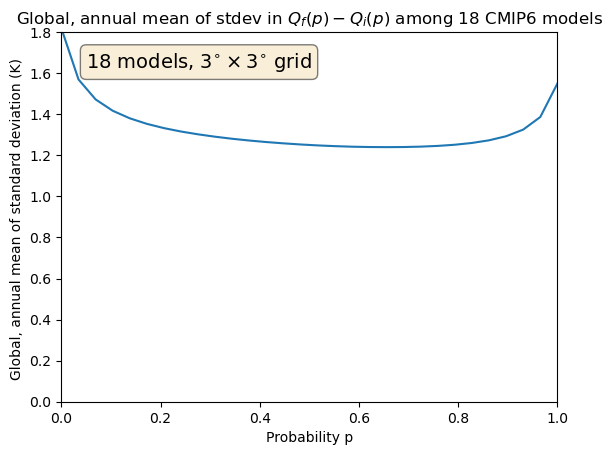

In [16]:
qano_std_agmean.plot()
plt.xlabel('Probability p')
plt.ylabel('Global, annual mean of standard deviation (K) ')
plt.title(r'Global, annual mean of stdev in $Q_f(p) -Q_i(p)$ among 18 CMIP6 models')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, r'18 models, $3^{\circ} \times 3^{\circ}$ grid', transform=plt.gca().transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.ylim(0,1.8)
plt.xlim(0,1.0)

(0.0, 1.0)

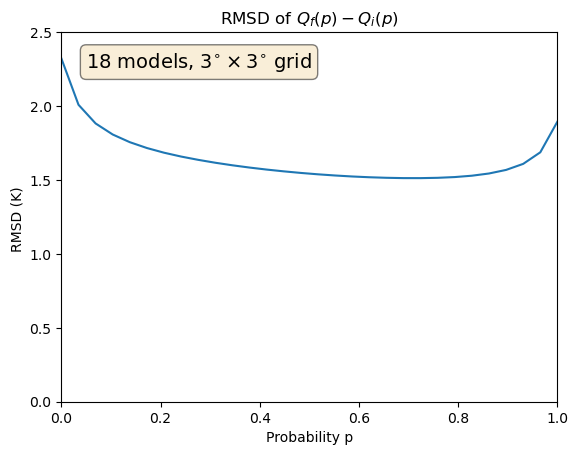

In [17]:
qano_rmsd.plot()
plt.xlabel('Probability p')
plt.ylabel('RMSD (K) ')
plt.title(r'RMSD of $Q_f(p) -Q_i(p)$')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, r'18 models, $3^{\circ} \times 3^{\circ}$ grid', transform=plt.gca().transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.ylim(0,2.5)
plt.xlim(0,1.0)

## Extra

In [ ]:
#################################### Land and Ocean-only curves ########################

In [ ]:
################# Extra #################

In [ ]:
# #Iterate Over dsets_ Dictionary:
# for k, v in tqdm(dsets_.items()):
#     expt_dsets = v.values()
    
#     if any([d is None for d in expt_dsets]):
#         print(f"Missing experiment for {k}")
#         continue
    
#     dsets = [v[expt].pipe(process_data)
                             
#                       for expt in expts]
    
    
#     # Check if any of the experiment datasets is empty and skip this model if so
#     # print('k,v=',k,dsets)
#     # print('-------')
#     if any([ds is None for ds in dsets]):
#         print(f"Skipping {k} because one of the experiment datasets is empty")
#         continue
        
#     # align everything along model dim
#     dsets_aligned[k] = xr.concat(dsets, join='outer',
#                                  dim=expt_da)
#     print(dsets_aligned[k])
#     print('-----------------')

In [ ]:
# def remove_feb29(ds):
#     """
#     Remove February 29th for leap years and adjust day indices.
    
#     Parameters:
#     - ds (xarray.Dataset): Input dataset

#     Returns:
#     - xarray.Dataset: Modified dataset without February 29th for leap years.
#     """
    
#     # Check if the dataset has 366 days
#     if ds.dims['dayofyear'] == 366:
#         # Identify leap years
#         leap_years = [year for year in ds['year'].values if is_leap(year)]
        
        
#          # Create a mask to identify February 29 in leap years
#         mask_feb29 = (ds['dayofyear'] == 60) & ds['year'].isin(leap_years)
        
#         # Drop the values for February 29 in leap years
#         ds = ds.where(~mask_feb29, drop=True)
        
#         # Now, adjust the day indices for days after Feb 29 in leap years
        
#         mask_postfeb29 = (ds['dayofyear'] > 60) & ds['year'].isin(leap_years)
#         ds['dayofyear'].values[mask_postfeb29] -= 1
        
#         # if ds.dims['dayofyear'] == 366:
#         #     print(ds.sel(dayofyear=366).sel(lat=chicago_lat,lon=chicago_lon,method='nearest').values)
        
# #         # Drop dayofyear=60 only for leap years
# #         ds = ds.where(~((ds['dayofyear'] == 60) & ds['year'].isin(leap_years)), drop=True)
        
# #         # Adjust dayofyear indices for days after February 29th only for leap years
# #         dayofyear = ds['dayofyear'].values
# #         mask = (dayofyear > 60) & np.isin(ds['year'].values, leap_years)
# #         dayofyear[mask] -= 1
# #       ds = ds.assign_coords(dayofyear=('dayofyear', dayofyear))

#     return ds



In [ ]:
# #Select data for specific location to plot
# df_loc = final_ds.to_dataframe().reset_index()
# df_eoc = final_ds.sel(experiment_id='ssp370').sel(year= slice(2071,2100)).to_dataframe().reset_index()
# df_pi  = final_ds.sel(experiment_id='historical').sel(year= slice(1850,1879)).to_dataframe().reset_index()
# df_loc

In [ ]:
# sns.relplot(data=df_loc,x="year", y="tasmax", hue='experiment_id',
#             kind="line", errorbar="sd", aspect=2);

In [ ]:
# quantiles = np.linspace(0,1.0,30)
# quantiles

In [ ]:
# df_eoc_quants                  = df_eoc.groupby('source_id')['tasmax'].quantile(quantiles).reset_index()
# df_eoc_quants.columns          = ['source_id','quantiles','tasmax']
# df_eoc_quants['experiment_id'] = 'ssp370'
# df_eoc_quants

In [ ]:
# df_pi_quants                  = df_pi.groupby('source_id')['tasmax'].quantile(quantiles).reset_index()
# df_pi_quants.columns          = ['source_id','quantiles','tasmax']
# df_pi_quants['experiment_id'] = 'historical'
# df_pi_quants

In [ ]:
# df_quants = pd.concat([df_eoc_quants, df_pi_quants],ignore_index=True)
# df_quants 

In [ ]:
# g = sns.relplot(data=df_eoc_quants,x="quantiles", y="tasmax",hue='experiment_id',
#             kind="line", errorbar="sd", aspect=2);
# g.fig.suptitle('son 30, EOC tasmax at Chicago: 21 CMIP6 models')

In [ ]:
# g = sns.relplot(data=df_quants,x="quantiles", y="tasmax",hue='experiment_id',
#             kind="line", errorbar="sd", aspect=2);
# g.fig.suptitle('son 30, tasmax at Chicago: 21 CMIP6 models')

In [ ]:
############## Anomalies ###########################

In [ ]:
# # Pivot the table based on experiment_id
# df_pivot = df_quants.pivot_table(index=['source_id', 'quantiles'], columns='experiment_id', values='tasmax')
# df_pivot

In [ ]:
# # Calculate the difference
# df_pivot['tasmax_ano'] = df_pivot['ssp370'] - df_pivot['historical']
# df_pivot
# # Reset the index to turn multi-index back to columns
# df_quant_ano = df_pivot.reset_index()[['source_id', 'quantiles', 'tasmax_ano']]
# df_quant_ano

In [ ]:
# g = sns.relplot(data=df_quant_ano,x="quantiles", y="tasmax_ano",
#             kind="line", errorbar="sd", aspect=2);
# g.fig.suptitle('son 30, tasmax anomaly at Chicago: 21 CMIP6 models')

In [ ]:
# # Group by quantiles and compute the standard deviation for Tasmax
# df_quantano_std = df_quant_ano.groupby('quantiles')['tasmax_ano'].std().reset_index()

# # Rename the column for clarity
# df_quantano_std.rename(columns={'tasmax_ano': 'tasmax_sdev'}, inplace=True)
# df_quantano_std

In [ ]:
# g = sns.relplot(data=df_quantano_std,x="quantiles", y="tasmax_sdev",
#             kind="line", errorbar="sd", aspect=2);
# g.fig.suptitle('son 30, tasmax std at Chicago: 21 CMIP6 models')